# Carga de datos


In [ ]:
# install libraries
!pip3 install scikit-learn-extra
!pip install scikit-fuzzy

     |████████████████████████████████| 1.7 MB 6.8 MB/s 
     |████████████████████████████████| 993 kB 6.8 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=e6c3fd4346295f79cc5ee6485e3e092236397325200997c96ece81d910edc2dd
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib
import librosa, librosa.display
import IPython.display as ipd

import sklearn
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import mixture
from scipy.cluster.hierarchy import linkage, fcluster
import skfuzzy as fuzz
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import v_measure_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import files

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
np.random.seed(1643558)
rst = np.random.get_state() # save random state

NameError: ignored

In [ ]:
"""
    ####################################
    'loaddata.*'
    
    loads and shows audio data
    
    uses LIBROSA. Insall e.g. with

    conda install -c conda-forge librosa
    ####################################
"""




task_names = [
 ['Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat'],
 ['Rain', 'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops'],
 ['Hen', 'Insects (flying)', 'Sheep', 'Crow', 
  'Wind', 'Pouring water', 'Toilet flush',  'Thunderstorm', 
  'Laughing', 'Brushing teeth'],
 ['Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps'],
 ['Door knock', 'Mouse click', 'Keyboard typing', 'Door, wood creaks', 'Can opening',
  'Washing machine'],
 ['Snoring',  'Drinking, sipping',
  'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking',
  'Church bells', 'Airplane', 'Fireworks', 'Hand saw'],
 ['Helicopter', 'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train']]


print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

task=4
class_names = task_names[task-1]
srate = 22050        # sampling rate
c = len(class_names) # no. of classes

# load data
data = np.load('adata%d.npy'%task)

n,d = data.shape  # size and (raw) dimension
nc = n//c         # samples per class

print('%d samples from %d classes'%(n,c))
print('Raw dimension is %d corresponding to %.1f seconds of audio'%(d,d/srate))

# set up labs
labs = np.int16(np.kron(np.arange(c),np.ones(nc)))



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
720 samples from 6 classes
Raw dimension is 66150 corresponding to 3.0 seconds of audio


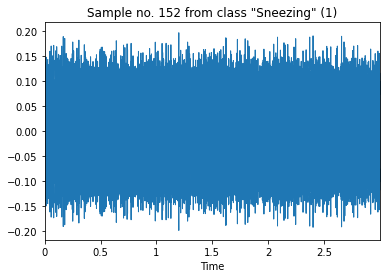

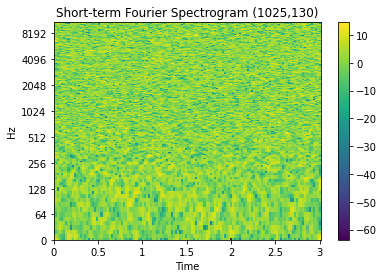

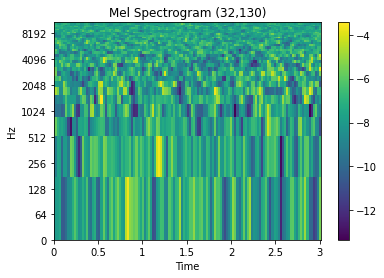

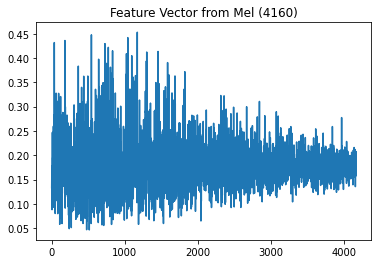

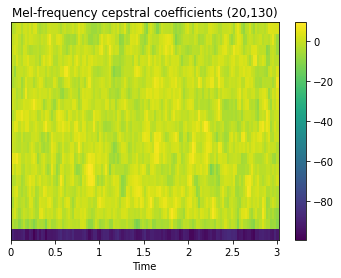

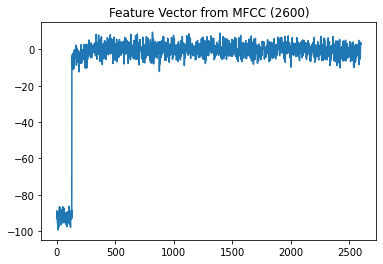

In [ ]:
# take a row of the data matrix
arow = np.random.randint(n)

sig = data[arow,:]

fig,ax = plt.subplots()
librosa.display.waveplot(sig,ax=ax)
ax.set_title('Sample no. %d from class "%s" (%d)'%(arow,class_names[labs[arow]],labs[arow]))
plt.show()

Power = np.abs(librosa.stft(sig))**2
librosa.display.specshow(librosa.power_to_db(Power), sr=srate, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('Short-term Fourier Spectrogram (%d,%d)'%Power.shape)
plt.show()

##########


Mel = librosa.feature.melspectrogram(y=sig, 
                                     sr=srate,n_mels=32)

librosa.display.specshow(librosa.power_to_db(Mel), sr=srate, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar()
plt.title('Mel Spectrogram (%d,%d)'%Mel.shape)
plt.show()

plt.plot(Mel.flatten())
plt.title('Feature Vector from Mel (%d)'%Mel.size)
plt.show()


##########


MFCC = librosa.feature.mfcc(y=sig, sr=srate, n_mfcc=20)
librosa.display.specshow(MFCC, sr=srate, x_axis='time', cmap='viridis')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (%d,%d)'%MFCC.shape)
plt.show()

plt.plot(MFCC.flatten())
plt.title('Feature Vector from MFCC (%d)'%MFCC.size)
plt.show()

# Use this in NoteBooks only

ipd.Audio(sig, rate=srate)

Option 1:  take time domain representation and reduce dimensionality
Dimension: 66150 -> 545
Resub. acc of a linear class.: 0.58 -> 0.88
Option 2: use Mel spectrograms
Dimension: 4160 -> 178
Resub. acc of a linear class.: 0.89 -> 0.55
Option 3: use MFCCs
Dimension: 2600 -> 479
Resub. acc of a linear class.: 0.88 -> 0.94


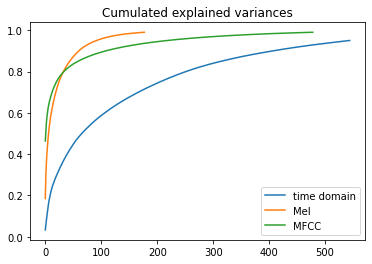

In [ ]:
###########
# CREATE DATASET

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
wc = LinearDiscriminantAnalysis()

y = labs

print('Option 1:  take time domain representation and reduce dimensionality')

pca = sklearn.decomposition.PCA(n_components=.95)
pca.fit(data)
X = pca.transform(data)
print('Dimension: %d -> %d'%(data.shape[1],X.shape[1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_),
         label='time domain')

print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(data,y).score(data,y),wc.fit(X,y).score(X,y)))


print('Option 2: use Mel spectrograms')

Xm = librosa.feature.melspectrogram(y=data[0,:],
                        sr=srate,n_mels=32).flatten()    
for s in range(1,n):
    Mel = librosa.feature.melspectrogram(y=data[s,:],
                        sr=srate,n_mels=32).flatten()    
    Xm = np.vstack([Xm,Mel])

pca = sklearn.decomposition.PCA(n_components=.99)    
pca.fit(Xm)
X = pca.transform(Xm)
print('Dimension: %d -> %d'%(Xm.shape[1],X.shape[1]))
plt.plot(np.cumsum(pca.explained_variance_ratio_),
         label='Mel')

print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(Xm,y).score(Xm,y),wc.fit(X,y).score(X,y)))

    
print('Option 3: use MFCCs')

Xf = librosa.feature.mfcc(y=data[0,:],
                        sr=srate,n_mfcc=20).flatten()    
for s in range(1,n):
    Mfcc = librosa.feature.mfcc(y=data[s,:],
                        sr=srate,n_mfcc=20).flatten()    
    Xf = np.vstack([Xf,Mfcc])

pca = sklearn.decomposition.PCA(n_components=.99)    
pca.fit(Xf)
X = pca.transform(Xf)
print('Dimension: %d -> %d'%(Xf.shape[1],X.shape[1]))    
plt.plot(np.cumsum(pca.explained_variance_ratio_),
         label='MFCC')

print('Resub. acc of a linear class.: %.2f -> %.2f'%(wc.fit(Xf,y).score(Xf,y),wc.fit(X,y).score(X,y)))

############
plt.title('Cumulated explained variances')
plt.legend()
plt.show()


In [ ]:
def prepare_data(n_components = 0.99):

  task, srate = 4, 22050

  data = np.load('adata%d.npy'%task)
  Xf = librosa.feature.mfcc(y=data[0,:],
                          sr=srate,n_mfcc=20).flatten()
  
  n,d = data.shape  # size and (raw) dimension
  
  for s in range(1,n):
      Mfcc = librosa.feature.mfcc(y=data[s,:],
                          sr=srate,n_mfcc=20).flatten()    
      Xf = np.vstack([Xf,Mfcc])

  pca = sklearn.decomposition.PCA(n_components=n_components)    
  pca.fit(Xf)
  X = pca.transform(Xf)

  c = 6 # no. of classes
  nc = n//c         # samples per class
  labs = np.int16(np.kron(np.arange(c),np.ones(nc)))
  
  return X, labs

# Clustering

In [ ]:
X, y = prepare_data()

## Métodos clustering

En primer lugar probamos distintos algoritmos de clustering.

### Jerárquico aglomerativo

Medida Fowlkes-Mallows para los distintos métodos de enlace.
------------------------------------------------------------
single: 0.404
complete: 0.376
ward: 0.312
average: 0.396
weighted: 0.392
centroid: 0.402
median: 0.402
Número de clusters predicho: [6, 6, 6, 6, 6, 6, 6]


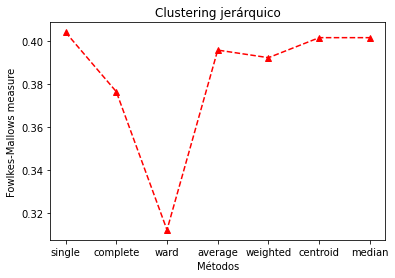

In [ ]:
### Clustering jerárquico aglomerativo
# No incorpora ningún argumento de tipo random_state

nclusters=6
allMethods = ('single','complete','ward','average','weighted','centroid','median')

v_measure = []
fowlkes_mallows_measure = []
nclustersPred=[]
for meth in allMethods:
    Z = linkage(X, meth)  # constructs the hierarchy
    
    clusters = fcluster(Z, nclusters, criterion='maxclust')
    nclustersPred.append(len(np.unique(clusters)))

    v_measure.append(v_measure_score(y, clusters))
    fowlkes_mallows_measure.append(fowlkes_mallows_score(y, clusters))

print("Medida Fowlkes-Mallows para los distintos métodos de enlace.")
print("------------------------------------------------------------")
for meth, fm in zip(allMethods, fowlkes_mallows_measure):
  print("{}: {:.3f}"\
        .format(meth, fm))
print("Número de clusters predicho: {}"\
      .format(nclustersPred)) #No tiene que ser necesariamente igual a nclusters   

fig,ax=plt.subplots()
ax.plot(allMethods, fowlkes_mallows_measure, marker="^",linestyle="--",color="r")
ax.set_xlabel("Métodos")
ax.set_ylabel("Fowlkes-Mallows measure")
ax.set_title("Clustering jerárquico")
plt.show()

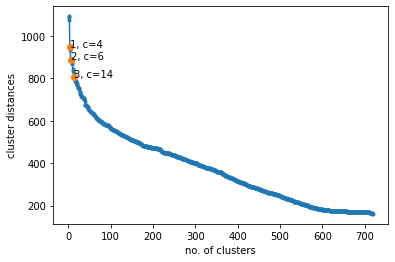

In [ ]:
# Best agglomerative clusterings
meth='single'
Z = linkage(X, meth)

ibests = np.argsort(-np.diff(Z[:,2]))
#ts = Z[ibests,2]
nclustersBest = Z.shape[0]-ibests

hwmny=3  # los tres mejores

# plot distances #####################################
plt.figure()
plt.plot(Z.shape[0]-np.arange(Z.shape[0]),Z[:,2],'.-')
plt.xlabel('no. of clusters')
plt.ylabel('cluster distances')
plt.plot(nclustersBest[:hwmny],Z[ibests[:hwmny],2],'o')
for b in range(hwmny):
    plt.text(1+nclustersBest[b],Z[ibests[b],2],'%d, c=%d'%(1+b,nclustersBest[b]))
plt.show()

Vemos que el mejor clustering según el criterio de ver cuánto salta el dendrograma es el de 4 clusters, seguido de el de 6 clusters.

### K-means

In [ ]:
### Clustering con k-means
# Asume que los clusters son hiperesféricos, del mismo tamaño y bien separados, con las muestras distribuidas normalmente entorno a su respectivo centroide.

scores=[]
np.random.set_state(rst)
for i in range(50):
  model = KMeans(n_clusters=6)
  ypreds = model.fit_predict(X)
  scores.append(fowlkes_mallows_score(y, ypreds))

print(np.mean(scores)) #Tiene en cuenta diferentes estados aleatorios

0.31752038705874897


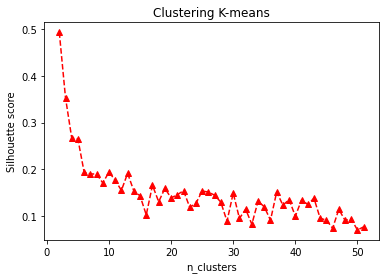

In [ ]:
scores=[]
for nclus in np.arange(50)+2:
  model = KMeans(n_clusters=nclus)
  ypreds = model.fit_predict(X)
  scores.append(silhouette_score(X, ypreds, metric='euclidean'))

fig,ax=plt.subplots()
ax.plot(np.arange(50)+2, scores, marker="^",linestyle="--",color="r")
ax.set_xlabel("n_clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Clustering K-means")
plt.show()

Usando k-means, el mejor cluster según el criterio silhouette es el que solo tiene 1 grupo. El criterio silhouette veremos que no es bueno en este caso.

### Fuzzy k-means

In [ ]:
### Clustering con fuzzy k-means

fuzzyness = 2

np.random.set_state(rst)
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X.transpose(), 6, fuzzyness,
    error=0.005, maxiter=1000)
ypreds = np.argmax(u,axis=0)

print(fowlkes_mallows_score(y, ypreds))

0.28539124953498995


### Gaussian mixture

In [ ]:
### Clustering con algoritmo EM (de mezcla de Gaussianas generalizado)

ncomps = 6
covtype = 'full'

scores=[]
np.random.set_state(rst)
for i in range(30):
  model = mixture.GaussianMixture(n_components=ncomps,
                                  covariance_type=covtype, 
                                  init_params='kmeans')
  model.fit(X)
  ypreds = model.predict(X)
  scores.append(fowlkes_mallows_score(y, ypreds))

print(np.mean(scores)) #Tiene en cuenta diferentes estados aleatorios

0.32841597423720026


### Mean-shift

Bandwidth:  517.3861762152778
number of estimated clusters : 5
0.3822068330745951


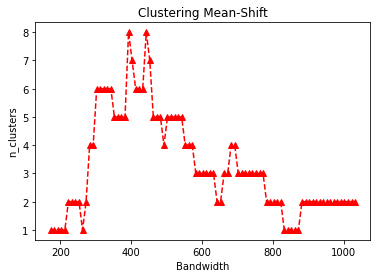

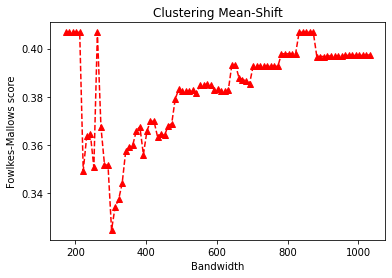

In [ ]:
### Clustering con mean-shift
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=None)
ms = MeanShift(bandwidth=bandwidth,
               bin_seeding=True, 
               cluster_all=True).fit(X) #No tiene ninguna componente aleatoria

labels = ms.labels_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique) - (1 if -1 in labels else 0) #La etiqueta -1 no estará si ponemos el parámetro cluster_all=True

print('Bandwidth: ' , bandwidth)
print("number of estimated clusters : %d" % n_clusters)
print(fowlkes_mallows_score(y, labels))

# Búsqueda alrededor del bandwidth estimado con estimate_bandwidth()
bandwidth = np.arange(bandwidth/3, 2*bandwidth, step=10)
n_clusters = []
scores = []
for bw in bandwidth:
  ms = MeanShift(bandwidth=bw,
                 bin_seeding=True,
                 cluster_all=True).fit(X)
  labels = ms.labels_
  labels_unique = np.unique(labels)
  n_clusters.append(len(labels_unique) - (1 if -1 in labels else 0))
  scores.append(fowlkes_mallows_score(y, labels))

fig,ax=plt.subplots()
ax.plot(bandwidth, n_clusters, marker="^",linestyle="--",color="r")
ax.set_xlabel("Bandwidth")
ax.set_ylabel("n_clusters")
ax.set_title("Clustering Mean-Shift")
plt.show()

fig,ax=plt.subplots()
ax.plot(bandwidth, scores, marker="^",linestyle="--",color="r")
ax.set_xlabel("Bandwidth")
ax.set_ylabel("Fowlkes-Mallows score")
ax.set_title("Clustering Mean-Shift")
plt.show()

Vemos que variando el ancho de banda podríamos conseguir un agrupamiento con 6 clusters, pero ni siquiera con esos se obtiene un buen parecido al etiquetado real.

## Etiquetado real

In [ ]:
# Valor de silhouette del etiquetado real
silhouette_score(X, y, metric='euclidean')

-0.05999807

Podemos mostrar para comparar el coeficiente Silhouette del etiquetado real. El hecho de que este coeficiente se encuentre entorno a 0 (incluso negativo) es indicativo de solape entre grupos, dado que suele acercarse a 1 cuando los clusters definidos por las etiquedas son densos y bien separados. En este caso el Silhouette no es una buena métrica para determinar el número de clusters.

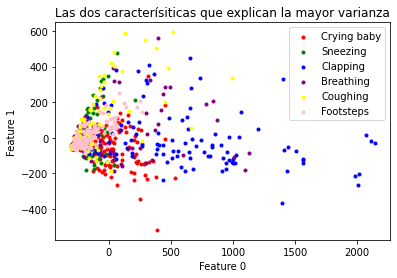

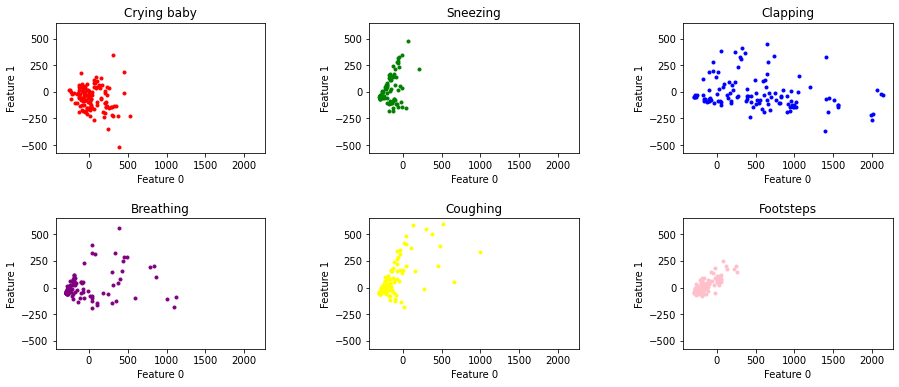

In [ ]:
### Plot de las dos primeras características del conjunto
colors = ['red','green','blue','purple','yellow','pink']
fig,ax=plt.subplots()
for i in range(0,720, 120):
  ax.scatter(X[i:i+120,0], X[i:i+120,1], marker=".", c=matplotlib.colors.CSS4_COLORS[colors[i//120]],
             label=class_names[i//120])
ax.set_xlabel("Feature 0")
ax.set_ylabel("Feature 1")
ax.set_title("Las dos caracterísiticas que explican la mayor varianza")
ax.legend()
plt.show()

xl = ax.get_xlim()
yl = ax.get_ylim()

fig,ax=plt.subplots(2,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.5)
ax = ax.ravel()
for i in range(0,720, 120):
  ax[i//120].scatter(X[i:i+120,0], X[i:i+120,1], marker=".",
                     c=matplotlib.colors.CSS4_COLORS[colors[i//120]])
  ax[i//120].set_xlabel("Feature 0")
  ax[i//120].set_ylabel("Feature 1")
  ax[i//120].set_xlim(xl)
  ax[i//120].set_ylim(yl)
  ax[i//120].set_title(class_names[i//120])
plt.show()

Se observa una gran cantidad de solape entre las clases, lo cual explica que los resultados del clustering no se parezcan al etiquetado real.

# Reducción del conjunto

In [ ]:
X, y = prepare_data()

A lo largo del trabajo probaremos tres métodos distintos de reducción: k-medoids, k-means y mixtura de gausianas. En todos las funciones se podrá ajustar el tamaño del conjunto y el estado aleatorio.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances


def kmedoids_reduce(X, size=0.5, rst=rst):

  N_CLASSES = 6
  STEP = 120 

  X_reduced = []
  X_test = []

  for i in range(0,720, STEP):
    np.random.set_state(rst)
    k_medoids = KMedoids(n_clusters=int(STEP*size), random_state=np.random.randint(2**32 - 1))
    k_medoids.fit(X[i:(i+STEP)])
      
    values_train = X[k_medoids.medoid_indices_ + i]
    X_reduced.append(values_train)

    test_indices = np.setdiff1d(np.arange(STEP), k_medoids.medoid_indices_)
    values_test = X[test_indices + i]
    X_test.append(values_test)

  X_reduced = np.array(X_reduced)
  X_reduced =  X_reduced.reshape(N_CLASSES*int(STEP*size),-1)
  X_test = np.array(X_test)
  X_test =  X_test.reshape(N_CLASSES*(STEP - int(STEP*size)),-1)

  return X_reduced, X_test


def kmeans_reduce(X, size=0.5, rst=rst):

  N_CLASSES = 6
  STEP = 120 

  X_reduced = []
  X_test = []

  for i in range(0,720, STEP):
    np.random.set_state(rst)
    k_means = KMeans(n_clusters=int(STEP*size), random_state=np.random.randint(2**32 - 1))
    k_means.fit(X[i:(i+STEP)])
      
    X_dist = k_means.fit_transform(X[i:(i+STEP)])
    representative_idx = np.argmin(X_dist, axis=0)
    values_train = X[representative_idx + i]
    X_reduced.append(values_train)

    test_indices = np.setdiff1d(np.arange(STEP), representative_idx)
    values_test = X[test_indices + i]
    X_test.append(values_test)

  X_reduced = np.array(X_reduced)
  X_reduced =  X_reduced.reshape(N_CLASSES*int(STEP*size),-1)
  X_test = np.array(X_test)
  X_test =  X_test.reshape(N_CLASSES*(STEP - int(STEP*size)),-1)

  return X_reduced, X_test


def gaussian_mixture_reduce(X, size=0.5, rst=rst):

  N_CLASSES = 6
  STEP = 120

  X_reduced = []
  X_test = []

  for i in range(0,720, STEP): #for each class
    '''
    score = []
    for j in range(1,11): #check with different number of components
      np.random.set_state(rst)
      model = mixture.GaussianMixture(n_components=j,
                                        covariance_type='full', 
                                        init_params='kmeans')
      model.fit(X[i:(i+STEP)])
      aic = model.aic(X[i:(i+STEP)])
      score.append(aic)
      score = np.array(score)
      idx = np.argmin(score) #select the model with the lowest aic ('the best')
      np.random.set_state(rst)
    '''#uncomment to select the number of components by aic criterion
       #else fix n_components
    np.random.set_state(rst)    
    model = mixture.GaussianMixture(n_components=3, # idx+1
                                      covariance_type='full', 
                                      init_params='kmeans')
    #print(idx+1)
    model.fit(X[i:(i+STEP)])
    if size<=0.5 :
      train_indices = []
      while len(train_indices) < int(STEP*size): 
        muestra, _ = model.sample(1) #get a random sample from the distribution
        d = euclidean_distances(X[i:(i+STEP)], muestra)
        train_indices.append(np.argmin(d)) #find the closest point, add it to train set
        train_indices = list(np.unique(np.array(train_indices))) #so points are not repeated

      train_indices = np.array(train_indices)
      values_train = X[train_indices + i]
      test_indices = np.setdiff1d(np.arange(STEP), train_indices)
      values_test = X[test_indices + i]
      X_reduced.append(values_train)
      X_test.append(values_test)
    else:
      test_indices = []
      while len(test_indices) < (STEP - int(STEP*size)): 
        muestra, _ = model.sample(1) #get a random sample from the distribution
        d = euclidean_distances(X[i:(i+STEP)], muestra)
        test_indices.append(np.argmin(d)) #find the closest point, add it to test set
        test_indices = list(np.unique(np.array(test_indices))) #so points are not repeated

      test_indices = np.array(test_indices)
      values_test = X[test_indices + i]
      train_indices = np.setdiff1d(np.arange(STEP), test_indices)
      values_train = X[train_indices + i]
      X_test.append(values_test)
      X_reduced.append(values_train)

  X_reduced = np.array(X_reduced)
  X_reduced =  X_reduced.reshape(N_CLASSES*int(STEP*size),-1)
  X_test = np.array(X_test)
  X_test =  X_test.reshape(N_CLASSES*(STEP - int(STEP*size)),-1)

  return X_reduced, X_test


def reduce(X, y, cluster_type='kmedoids', size=0.5, rst=rst):
  #cluster_type must be one of: 'kmedoids', 'kmeans', 'gaussian_mixture'
  
  N_CLASSES = 6
  STEP = 120 # There are 120 elements of each class.
  
  y_reduced = np.int16(np.kron(np.arange(N_CLASSES),np.ones(int(STEP*size))))
  y_test = np.int16(np.kron(np.arange(N_CLASSES),np.ones(STEP - int(STEP*size))))

  if cluster_type=='kmedoids':
    X_reduced, X_test = kmedoids_reduce(X, size, rst)
  elif cluster_type=='kmeans':
    X_reduced, X_test =  kmeans_reduce(X, size, rst)
  elif cluster_type=='gaussian_mixture':
    X_reduced, X_test = gaussian_mixture_reduce(X, size, rst)
  else:
    print("Error: unknown method.")

  return X_reduced, X_test, y_reduced, y_test

Como se puede apreciar, existen diversas maneras de reducir el conjunto. Vamos a descartar aquellas que no resulten utiles. Algunos problemas de los conjuntos serán dificiles de ver sin haber empleado esos conjuntos para el entrenamiento. Así que vamos a definir una función que entrene y testee un árbol de decisión. Previamente habrá que declarar una función que evalue los modelos, que nos será de gran utilidad en las siguientes secciones.

In [ ]:
def eval_model(clf, X_train, y_train, X_test, y_test):
  print('OA train %0.2f' % clf.score(X_train, y_train)) 
  preds_train = clf.predict(X_train)
  print('Kappa train %0.2f' % metrics.cohen_kappa_score(y_train,preds_train))
  print('AUC train %0.2f' % metrics.roc_auc_score(y_train, clf.predict_proba(X_train), multi_class='ovr'))
  
  print('OA test %0.2f' % clf.score(X_test, y_test))
  preds_test = clf.predict(X_test)
  print('Kappa test %0.2f' % metrics.cohen_kappa_score(y_test,preds_test))
  print('AUC test %0.2f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr'))

  CM = metrics.confusion_matrix(y_test,preds_test)
  print(CM)

In [ ]:
### Función que entrena y testea un árbol de decisión
def reduction_test(X_train, X_test, y_train, y_test):
  criterion = ['entropy', 'gini']
  splitter = ['random', 'best']
  max_depth = [3, 8, None]
  max_leaf_nodes = [8, 16, None]
  min_samples_split = [2, 3]
  min_samples_leaf = [1, 2]

  tuned_parameters = { 'criterion': criterion,'splitter': splitter,'max_depth': max_depth, 'max_leaf_nodes': max_leaf_nodes,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf}    

  np.random.set_state(rst)
  clf = GridSearchCV(DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
  clf.fit(X_train,y_train)
  clf = clf.best_estimator_
  eval_model(clf, X_train, y_train, X_test, y_test)

Veamos qué ocurre si usamos el conjunto complementario al de la reducción como conjunto de test.

In [ ]:
X_train, X_test, y_train, y_test = reduce(X, y)
reduction_test(X_train, X_test, y_train, y_test)

OA train 0.69
Kappa train 0.63
AUC train 0.89
OA test 0.19
Kappa test 0.03
AUC test 0.61
[[ 8  0 52  0  0  0]
 [29  9  3 14  0  5]
 [12  3 38  6  0  1]
 [12  0 29  4  0 15]
 [26  1 15  8  0 10]
 [27  2 16  6  0  9]]


Acabamos de comprobar que no es buena idea utilizar el complementario del conjunto de entrenamiento como conjunto de test, ya que las muestras no son i.d.d., prueba de ello que los resultados están totalmente sesgados.

En segundo lugar, demostraremos que el resultado con el método de kmedoids es independiente del estado aleatorio.

In [ ]:
np.random.seed(1643500)
rst2 = np.random.get_state()
np.random.seed(1643300)
rst3 = np.random.get_state()

In [ ]:
def set_comparator(X_reduced, X_reduced2):
  nrows, ncols = X_reduced.shape
  dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [X_reduced.dtype]}

  return len(np.intersect1d(X_reduced.view(dtype), X_reduced2.view(dtype)))

In [ ]:
for method in ['kmedoids', 'kmeans', 'gaussian_mixture']:
  X_reduced, _, _, _ = reduce(X, y, method, rst=rst, size=0.85)
  X_reduced2, _, _, _ = reduce(X, y, method, rst=rst2, size=0.85)
  X_reduced3, _, _, _ = reduce(X, y, method, rst=rst3, size=0.85)
  
  print("{}: set 1 has {}/{} elements in common with set 2"\
        .format(method, set_comparator(X_reduced, X_reduced2), len(X_reduced)))
  print("{}: set 1 has {}/{} elements in common with set 3"\
        .format(method, set_comparator(X_reduced, X_reduced3), len(X_reduced)))

kmedoids: set 1 has 612/612 elements in common with set 2
kmedoids: set 1 has 612/612 elements in common with set 3
kmeans: set 1 has 585/612 elements in common with set 2
kmeans: set 1 has 588/612 elements in common with set 3
gaussian_mixture: set 1 has 536/612 elements in common with set 2
gaussian_mixture: set 1 has 533/612 elements in common with set 3


En principio todos los métodos tienen una componente aleatoria, pero vemos que con k-medioides siempre se obtiene el mismo conjunto. Sería mejor que tuviera un poco de variabilidad, para poder testear en distintos conjuntos. Con k-means se obtienen conjuntos más distintos y con gaussian_mixture aún más. Téngase en cuenta que como mínimo han de tener 504 elementos en común (al poner tamaño al 85%).

Calculemos ahora los conjuntos reducidos con dos tamaños distintos mediante los tres métodos y con distintos estados aleatorios.

In [ ]:
inputs = {}

for method in ['kmedoids', 'kmeans', 'gaussian_mixture']:
  for i, rsti in enumerate([rst, rst2, rst3]): 
    for size in [520/720, 0.85]:
      X_reduced, _, y_reduced, _ = reduce(X, y, method, size=size, rst=rst)
      
      np.random.set_state(rst)    
      X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=.302,random_state=np.random.randint(2**32 - 1))

      key = ""
      key += 'kd' if method == 'kmedoids' else ('km' if method == 'kmeans' else 'gm')
      key +=  str(i) + "_"
      key += "l" if size < 0.85 else "xl"
      inputs[key] = [X_train, X_test, y_train, y_test]
  
    if method == 'kmedoids': break # just one rst 


Testeamos estos conjuntos ajustando un árbol.

In [ ]:
for key, (X_train, X_test, y_train, y_test) in inputs.items():
  print("RESULTS with: ", key)
  reduction_test(X_train, X_test, y_train, y_test)
  print("=====================")

RESULTS with:  kd0_l
OA train 0.50
Kappa train 0.40
AUC train 0.83
OA test 0.46
Kappa test 0.35
AUC test 0.77
[[23  0  6  0  0  0]
 [ 3  8  0 14  0  0]
 [ 6  0 17  4  0  0]
 [ 2  2  3 16  0  0]
 [ 6  6  1 10  0  3]
 [ 4  2  1 12  0  7]]
RESULTS with:  kd0_xl
OA train 0.56
Kappa train 0.48
AUC train 0.85
OA test 0.40
Kappa test 0.28
AUC test 0.75
[[22  0  9  0  3  0]
 [ 0 11  0  2 14  0]
 [ 4  1 19  5  0  0]
 [ 1  8  6 10  4  6]
 [ 3  8  3  3  5  4]
 [ 1  0  5 10 11  7]]
RESULTS with:  km0_l
OA train 0.54
Kappa train 0.44
AUC train 0.84
OA test 0.46
Kappa test 0.35
AUC test 0.77
[[22  6  0  0  0  1]
 [ 1 13  0  0  9  2]
 [11  0 11  0  4  1]
 [ 1  3  1  0  8 10]
 [ 0  7  0  0  9 10]
 [ 2  1  0  0  6 17]]
RESULTS with:  km0_xl
OA train 0.63
Kappa train 0.56
AUC train 0.89
OA test 0.48
Kappa test 0.37
AUC test 0.74
[[21  6  5  1  0  1]
 [ 1 21  0  1  4  0]
 [ 1  4 19  0  4  1]
 [ 2 11  4  1  3 14]
 [ 0 12  2  1  7  4]
 [ 1  8  0  3  3 19]]
RESULTS with:  km1_l
OA train 0.54
Kappa train 0.4

Los peores resultados se obtienen con la reducción mediante k-medioides (algunas clases no se predicen nunca siquiera). Con k-means son mejores con el tamaño grande. La mezcla de Gaussianas es la que da mayor overall accuracy. Además es la que tiene mayor proporción de valores grandes en la diagonal de la matriz de confusión, lo que indica que la mayoría de las muestras las clasifica bien.

Podemos representar las dos primeras características y por colores los valores que quedan dentro de la reducción (en azul) y los que quedan fuera (en rojo). Esto nos indicará si la reducción es representativa del conjunto original.

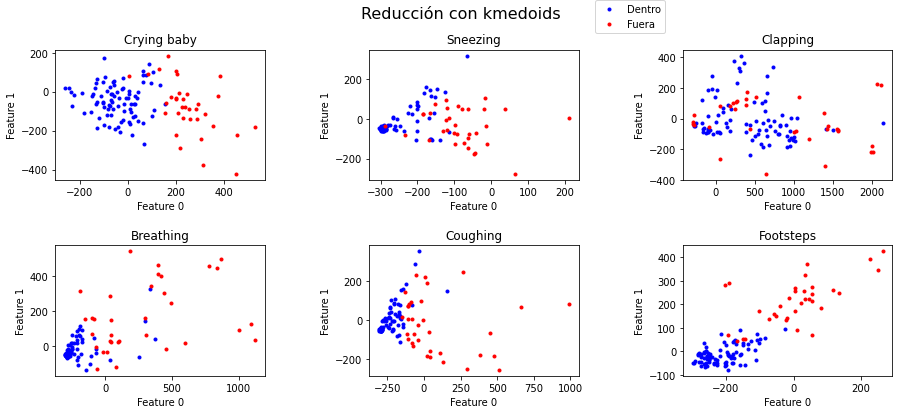

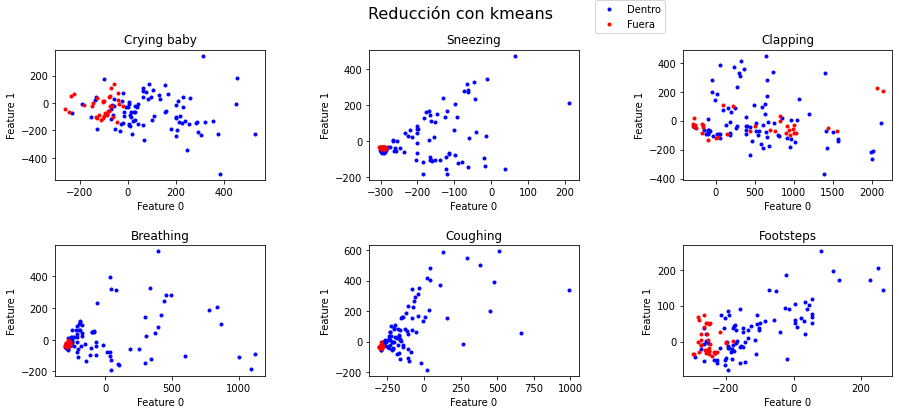

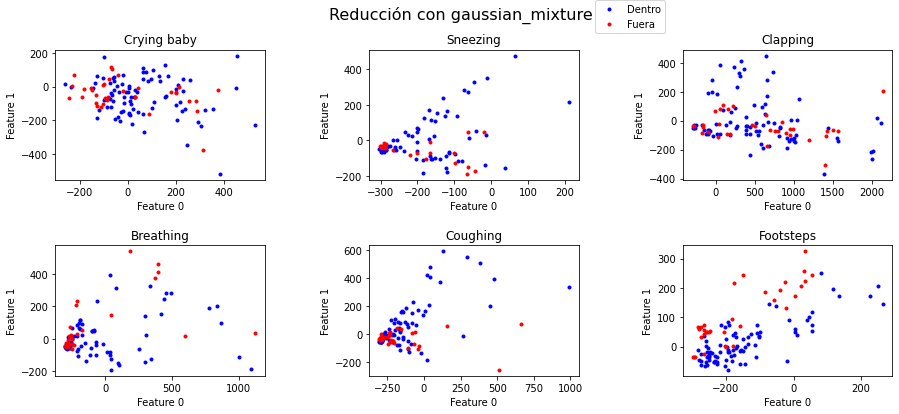

In [ ]:
### Gráficos de las reducciones
for meth in ['kmedoids', 'kmeans', 'gaussian_mixture']:
  X_reduced, X_out, y_reduced, y_out = reduce(X, y, cluster_type=meth, size=520/720)

  step_reduced = X_reduced.shape[0]//6
  step_out = X_out.shape[0]//6

  fig,ax=plt.subplots(2,3, figsize=(15, 6))
  fig.subplots_adjust(hspace = .5, wspace=.5)
  ax = ax.ravel()
  for i in range(6):
    ax[i].scatter(X_reduced[i*step_reduced:(i+1)*step_reduced,0], 
                  X_reduced[i*step_reduced:(i+1)*step_reduced,1], 
                  marker=".",c='blue', label="Dentro")
    ax[i].scatter(X_out[i*step_out:(i+1)*step_out,0], 
                  X_out[i*step_out:(i+1)*step_out,2], 
                  marker=".",c='red', label = "Fuera")
    ax[i].set_xlabel("Feature 0")
    ax[i].set_ylabel("Feature 1")
    ax[i].set_title(class_names[i])
    ax[i].legend()
  fig.suptitle('Reducción con '+meth, fontsize=16)
  handles, labels = ax[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.62,0.97))
  [r.get_legend().remove() for r in ax]
  plt.show()

La reducción mediante k-medioides está muy sesgada. Tiende a coger valores donde hay mucha densidad y ninguno de zonas menos densas. Este método nos dará un conjunto no representativo. K-means y mezcla de gaussianas son mejores. K-means reparte las zonas densas entre dentro y fuera de la reducción y da importancia a puntos alejados. Gaussian_mixture también, y además los puntos parecen distribuidos más aleatoriamente.

In [ ]:
#Seleccionamos dos conjuntos reducidos para continuar
X_train_A, X_test_A, y_train_A, y_test_A = inputs['km0_xl']
X_train_B, X_test_B, y_train_B, y_test_B = inputs['gm0_xl']

# Aprendizaje supervisado

En la siguiente sección se resolverá el problema de clasificación con las principales técnicas de aprendizaje supervisado vistas en clase.

## Decision Tree

In [ ]:
#Set A: kmeans
#Set B: gaussian_mixture

np.random.set_state(rst)
clf = DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_A,y_train_A)

DecisionTreeClassifier(random_state=2423474328)

In [ ]:
eval_model(clf, X_train_A, y_train_A, X_test_A, y_test_A)

OA train 1.00
Kappa train 1.00
AUC train 1.00
OA test 0.35
Kappa test 0.22
AUC test 0.61
[[15  4  8  1  5  1]
 [ 1  7  2  2 12  3]
 [ 7  1 14  3  4  0]
 [ 3  3  7  8  2 12]
 [ 0 11  2  3  6  4]
 [ 0  2  3 10  4 15]]


In [ ]:
print('Tree depth =',clf.get_depth())
print('Number of leaves =',clf.get_n_leaves())
print('Tree size =',clf.tree_.node_count)

Tree depth = 12
Number of leaves = 88
Tree size = 175


Como podemos observar se produce un inequivoco sobreajuste al utilizar el modelo de árbol de decisión por defecto. Por ello, debemos ajustar los parámetros hasta dar con el modelo óptimo.

In [ ]:
criterion = ['entropy', 'gini']
splitter = ['random', 'best']
max_depth = [3, 8, None]
max_leaf_nodes = [8, 16, None]
min_samples_split = [2, 3]
min_samples_leaf = [1, 2]

tuned_parameters = { 'criterion': criterion,'splitter': splitter,'max_depth': max_depth, 'max_leaf_nodes': max_leaf_nodes,
                     'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}    

np.random.set_state(rst)
clf_A = GridSearchCV(DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_A.fit(X_train_A,y_train_A)
clf_A = clf_A.best_estimator_

np.random.set_state(rst)
clf_B = GridSearchCV(DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_B.fit(X_train_B,y_train_B)
clf_B = clf_B.best_estimator_

if clf_A.score(X_test_A, y_test_A) > clf_B.score(X_test_B, y_test_B):
  print("Best model is A, with parameters: {}"\
        .format(clf_A.get_params))
else:
  print("Best model is B, with parameters: {}"\
        .format(clf_B.get_params))

Best model is B, with parameters: <bound method BaseEstimator.get_params of DecisionTreeClassifier(criterion='entropy', max_depth=8, max_leaf_nodes=16,
                       random_state=2423474328)>


In [ ]:
eval_model(clf_B, X_train_B, y_train_B, X_test_B, y_test_B)

OA train 0.63
Kappa train 0.56
AUC train 0.89
OA test 0.48
Kappa test 0.38
AUC test 0.78
[[15  7 10  0  1  1]
 [ 2 11  0  5  8  1]
 [ 5  0 22  0  1  1]
 [ 0  4  9  4  7 11]
 [ 1  4  1  4 11  5]
 [ 1  0  0  0  7 26]]


In [ ]:
print('Tree depth =',clf.get_depth())
print('Number of leaves =',clf.get_n_leaves())
print('Tree size =',clf.tree_.node_count)

Tree depth = 12
Number of leaves = 88
Tree size = 175


Gracias al ajuste de parámetros hemos conseguido acabar con el overfitting. Para este ejemplo concreto da mejores resultados el conjunto reducido por mezcla de gausianas que el de kmedias. Antes de pasar al siguiente apartado, vamos a probar el método de post-pruning.

In [ ]:
### testing post-pruning
np.random.set_state(rst)
clf = DecisionTreeClassifier(criterion='entropy', random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_B, y_train_B)
path = clf.cost_complexity_pruning_path(X_train_B, y_train_B)
ccp_alphas = path.ccp_alphas

tuned_parameters = {'ccp_alpha': ccp_alphas}  

np.random.set_state(rst)
clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=10,n_jobs=-1,verbose=0)
clf.fit(X_train_B, y_train_B)
clf = clf.best_estimator_
print(clf.get_params)

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.04982856681700665, criterion='entropy',
                       random_state=2423474328)>


In [ ]:
eval_model(clf, X_train_B, y_train_B, X_test_B, y_test_B)

OA train 0.54
Kappa train 0.45
AUC train 0.85
OA test 0.43
Kappa test 0.32
AUC test 0.77
[[12 10 10  0  2  0]
 [ 2  9  0  0 15  1]
 [ 4  1 22  0  2  0]
 [ 0  3  9  0 14  9]
 [ 0  4  1  0 16  5]
 [ 1  0  0  0 13 20]]


La poda a posteriori no supone ninguna mejora respecto a la puntuación obtenida anteriormente.

## SVM

In [ ]:
np.random.set_state(rst)
clf = svm.SVC(probability=True, random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_A, y_train_A)

SVC(probability=True, random_state=2423474328)

In [ ]:
eval_model(clf, X_train_A, y_train_A, X_test_A, y_test_A)

OA train 0.79
Kappa train 0.75
AUC train 0.98
OA test 0.53
Kappa test 0.44
AUC test 0.84
[[29  2  0  0  2  1]
 [ 1 20  0  0  6  0]
 [ 1  2 21  0  5  0]
 [ 3 14 10  1  2  5]
 [ 1 11  0  0 12  2]
 [ 1 15  0  1  2 15]]


Con los parámetros por defecto ya obtenemos mejores resultados que en el método anterior. Vamos a ajustar los hiperparámetros del modelo y a ponerlo a prueba con los dos conjuntos de entrenamiento.

In [ ]:
gammas = np.logspace(-6, 2, 10)
Cs = np.logspace(-2, 2, 10)
tuned_parameters = { 'C': Cs, 'gamma': gammas, 'probability':[True]}    

np.random.set_state(rst)
clf_A = GridSearchCV(svm.SVC(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_A.fit(X_train_A, y_train_A)
clf_A=clf_A.best_estimator_

np.random.set_state(rst)
clf_B = GridSearchCV(svm.SVC(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_B.fit(X_train_B, y_train_B)
clf_B = clf_B.best_estimator_

if clf_A.score(X_test_A, y_test_A) > clf_B.score(X_test_B, y_test_B):
  print("Best model is A, with parameters: {}"\
        .format(clf_A.get_params))
else:
  print("Best model is B, with parameters: {}"\
        .format(clf_B.get_params))

Best model is A, with parameters: <bound method BaseEstimator.get_params of SVC(C=4.6415888336127775, gamma=1e-06, probability=True,
    random_state=2423474328)>


In [ ]:
eval_model(clf_A, X_train_A, y_train_A, X_test_A, y_test_A)

OA train 0.84
Kappa train 0.80
AUC train 0.99
OA test 0.55
Kappa test 0.46
AUC test 0.87
[[27  2  1  2  1  1]
 [ 1 19  0  0  7  0]
 [ 0  2 22  1  4  0]
 [ 1 12  6  8  3  5]
 [ 0 13  0  0 10  3]
 [ 1 11  0  3  4 15]]


En esta ocasión no hemos tenido tanto exito como en la subsección anterior. No obstante hemos consegido aumentar unas decimas.

## MLP

Para el modelo de redes neuronales es más que recomendable normalizar los datos.

In [ ]:
# Normalizate data
X_train_A_norm = (X_train_A - X_train_A.mean())/X_train_A.std()
X_test_A_norm = (X_test_A - X_test_A.mean())/X_test_A.std()
X_train_B_norm = (X_train_B - X_train_B.mean())/X_train_B.std()
X_test_B_norm = (X_test_B - X_test_B.mean())/X_test_B.std()


np.random.set_state(rst)
clf = MLPClassifier(random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_A_norm, y_train_A)
eval_model(clf, X_train_A_norm, y_train_A, X_test_A_norm, y_test_A)

OA train 1.00
Kappa train 1.00
AUC train 1.00
OA test 0.43
Kappa test 0.31
AUC test 0.76
[[14  6  5  4  2  3]
 [ 1 10  0  4 11  1]
 [ 0  1 22  3  3  0]
 [ 1  4  4 14  6  6]
 [ 0  7  1  6 10  2]
 [ 0  6  0 11  8  9]]


In [ ]:
alphas = np.logspace(-3, 3, 5)
neurons = [[i,j] for i in range(5,12,3) for j in range(2,6,2)]
tuned_parameters = {'solver': ['lbfgs'], 'alpha': alphas, 
                    'hidden_layer_sizes': neurons,'random_state': [np.random.randint(2**32 - 1)]}


np.random.set_state(rst)
clf_A = GridSearchCV(MLPClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_A.fit(X_train_A_norm, y_train_A)
clf_A = clf_A.best_estimator_

np.random.set_state(rst)
clf_B = GridSearchCV(MLPClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_B.fit(X_train_B_norm, y_train_B)
clf_B = clf_B.best_estimator_

if clf_A.score(X_test_A_norm, y_test_A) > clf_B.score(X_test_B_norm, y_test_B):
  print("Best model is A, with parameters: {}"\
        .format(clf_A.get_params))
else:
  print("Best model is B, with parameters: {}"\
        .format(clf_B.get_params))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Best model is A, with parameters: <bound method BaseEstimator.get_params of MLPClassifier(alpha=31.622776601683793, hidden_layer_sizes=[11, 4],
              random_state=1344648493, solver='lbfgs')>


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
eval_model(clf_A, X_train_A_norm, y_train_A, X_test_A_norm, y_test_A)

OA train 0.95
Kappa train 0.94
AUC train 0.99
OA test 0.47
Kappa test 0.36
AUC test 0.81
[[21  4  2  7  0  0]
 [ 1 15  0  4  6  1]
 [ 2  1 21  5  0  0]
 [ 0  3  8  9  6  9]
 [ 2  2  1 11  8  2]
 [ 0  2  1 12  6 13]]


Una vez más se puede ver como un modelo más complejo no implica mejores resultados. A pesar incluso con ajuste de imperparámetros seguimos obteniendo peores resultados que en SVM, que queda como el método más preciso para resolver este problema.


# Ranking de características

En este apartado se empleará la biblioteca SHAP, que calcula la contribución de cada variable en base a sus valores de Shapley. En memoria encontrarán una explicación más detallada de como funciona a bajo nivel.

In [ ]:
!pip3 install shap
import shap

     |████████████████████████████████| 564 kB 29.9 MB/s 


## Decision Tree

Comenzamos definiendo una función que nos devuelva las características de un árbol de decisión que tengan alguna importancia, y que además sirva para mostrar por pantalla una gráfica con el ranking.

In [ ]:
def tree_feature_selector(clf, Plot = False):

  if Plot:
    fig, ax = plt.subplots()
    plt.barh(list(range(479))[0:12],sorted(clf.feature_importances_)[-12:],
                   tick_label= ['Feature ' + str(x) for x in np.argsort(clf.feature_importances_)[-12:]],
              )
    ax.set_xlabel("Mean decrease in impurity")
    plt.show()

  return clf.feature_importances_ > 0

Definimos otra que, dado un clasificador, un conjunto de background y uno de test, calcule los valores de Shapley con el método de kernel y nos muestre en un diagrama de barras el ranking con la contribución de cada variable.

In [ ]:
def explainer(clf, X_train, X_test):
    f_explainer = shap.KernelExplainer(clf.predict_proba, X_train, verbose = False)
    shap_values = f_explainer.shap_values(X_test, nsamples=250)
    shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=['Crying baby', 'Sneezing', 'Clapping', 'Breathing', 'Coughing', 'Footsteps'])

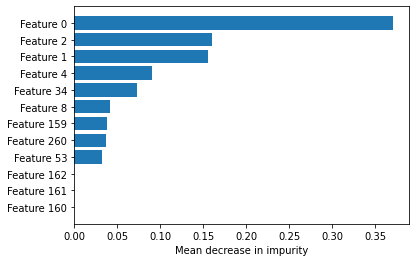

OA train 0.63
Kappa train 0.56
AUC train 0.89
OA test 0.48
Kappa test 0.38
AUC test 0.78
[[15  7 10  0  1  1]
 [ 2 11  0  5  8  1]
 [ 5  0 22  0  1  1]
 [ 0  4  9  4  7 11]
 [ 1  4  1  4 11  5]
 [ 1  0  0  0  7 26]]


In [ ]:
np.random.set_state(rst)
clf = DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1), 
                             criterion='entropy', max_depth=8, max_leaf_nodes=16)

clf.fit(X_train_B, y_train_B)

feature_selection = tree_feature_selector(clf, Plot=True)
eval_model(clf, X_train_B, y_train_B, X_test_B, y_test_B)

El background se obtiene mediante el método de kmedias de SHAP, que realizará una reducción similar a la vista en apartados anteriores.

El explainer muestra por pantalla un output muy extenso, tras esa gran cantidad de texto se encuentra la gráfica.

  0%|          | 0/185 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter 

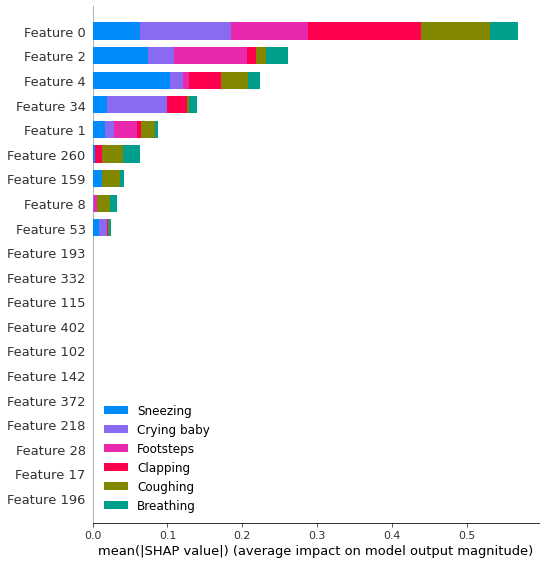

In [ ]:
background = shap.kmeans(X_train_B, 100) # summarize the background samples
explainer(clf, background, X_test_B)

Se aprecia como independientemente de la ténica que utilicemos para establecer el ranking, las variables son las mismas variando ligeramente el orden. Si tenemos que elegir entre uno de los dos métodos, siempre será mejor el de ganancia promedio de pureza por división, ya que requiere un tiempo de ejecución significantemente menor al de SHAP.

A continuación vamos a entrenar el modelo pero sólo con las variables relevantes.

In [ ]:
np.random.set_state(rst)
clf_sel = DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1), 
                             criterion='entropy', max_depth=8, max_leaf_nodes=16)

clf_sel.fit(X_train_B[:,feature_selection], y_train_B)
print('Initial input shape', X_train_B.shape)
print('Reduced input shape', X_train_B[:,feature_selection].shape)
eval_model(clf_sel, X_train_B[:,feature_selection], y_train_B, X_test_B[:,feature_selection], y_test_B)

Initial input shape (427, 479)
Reduced input shape (427, 9)
OA train 0.63
Kappa train 0.56
AUC train 0.89
OA test 0.48
Kappa test 0.38
AUC test 0.78
[[15  7 10  0  1  1]
 [ 2 11  0  5  8  1]
 [ 5  0 22  0  1  1]
 [ 0  4  9  4  7 11]
 [ 1  4  1  4 11  5]
 [ 1  0  0  0  7 26]]


El resultado final es el mismo.

## SVM

Las SVM no constan de un atributo que indique que variables son más importantes. Es por ello que nos decantamos por utilizar SHAP para resolver el problema de establecer un ranking.

In [ ]:
np.random.set_state(rst)
clf = svm.SVC(verbose=True, probability=True, random_state=np.random.randint(2**32 - 1),
              C = 4.6415888336127775, gamma = 1e-06, kernel = 'rbf')

clf.fit(X_train_A, y_train_A)
eval_model(clf, X_train_A, y_train_A, X_test_A, y_test_A)

[LibSVM]OA train 0.84
Kappa train 0.80
AUC train 0.99
OA test 0.55
Kappa test 0.46
AUC test 0.87
[[27  2  1  2  1  1]
 [ 1 19  0  0  7  0]
 [ 0  2 22  1  4  0]
 [ 1 12  6  8  3  5]
 [ 0 13  0  0 10  3]
 [ 1 11  0  3  4 15]]


  0%|          | 0/185 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter 

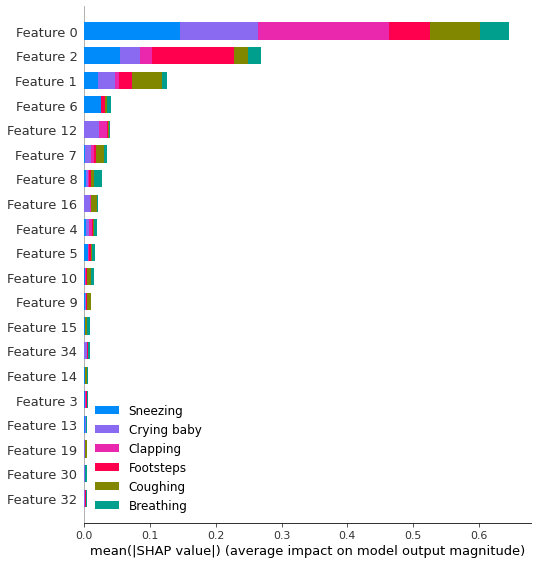

In [ ]:
background = shap.kmeans(X_train, 100) # summarize the background samples
explainer(clf, background, X_test)

Como se puede apreciar, el orden de importancia no corresponde con el número de componente principal. No obstante, las primeras componentes ostentar posiciones y valores de Shapley más altos. 

In [ ]:
feature_selection = [0, 2, 1, 6, 12, 7, 8, 16, 4, 5, 10, 9, 15, 34, 14, 3, 13, 19, 30, 32]

np.random.set_state(rst)
clf_sel = svm.SVC(verbose=True, probability=True, random_state=np.random.randint(2**32 - 1),
              C = 4.6415888336127775, gamma = 1e-06, kernel = 'rbf')


clf_sel.fit(X_train_A[:,feature_selection], y_train)
print('Initial input shape', X_train_A.shape)
print('Reduced input shape', X_train_A[:,feature_selection].shape)
eval_model(clf_sel, X_train_A[:,feature_selection], y_train_A, X_test_A[:,feature_selection], y_test_A)

[LibSVM]Initial input shape (427, 479)
Reduced input shape (427, 20)
OA train 0.70
Kappa train 0.64
AUC train 0.95
OA test 0.57
Kappa test 0.49
AUC test 0.86
[[27  2  3  0  1  1]
 [ 0 24  0  0  3  0]
 [ 2  1 21  2  3  0]
 [ 2 13  3  9  3  5]
 [ 0 12  0  2 10  2]
 [ 1 11  0  3  4 15]]


Incluso habiendo reducido en gran medida la dimensionalidad, hemos conseguido superar los resultados y batir los records de la sección anterior. Contamos ahora con un modelo más rápido y más preciso.

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

np.random.set_state(rst)
clf = MLPClassifier(random_state=np.random.randint(2**32 - 1), alpha = 31.622776601683793, 
                    hidden_layer_sizes = [11, 4], solver = 'lbfgs')

clf.fit(X_train_A_norm, y_train_A)
eval_model(clf, X_train_A_norm, y_train_A, X_test_A_norm, y_test_A)

OA train 0.93
Kappa train 0.92
AUC train 0.99
OA test 0.46
Kappa test 0.36
AUC test 0.81
[[22  4  1  7  0  0]
 [ 1 14  0  4  7  1]
 [ 2  1 20  5  0  1]
 [ 0  3  8 10  6  8]
 [ 1  3  1 12  7  2]
 [ 0  0  1 12  8 13]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


  0%|          | 0/185 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter 

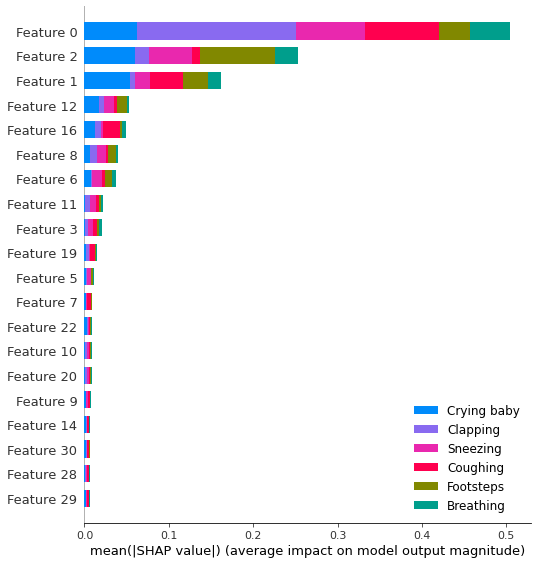

In [ ]:
background = shap.kmeans(X_train_A_norm, 100) # summarize the background samples
explainer(clf, background, X_test_A_norm)

Al igual que en el apartado anterior, en la clasificación de pisadas interviene más la componente 2, que la 0, a pesar de aportar menor información. En el resto de categorías la que más contribuye a la predicción es la componente 0, como era esperable. Los aplausos son la clase con valores de Shapley más altos.


In [ ]:
feature_selection = [0, 2, 1, 12, 16, 8, 6, 11, 3, 19, 5, 7, 22, 10, 20, 9, 14, 30, 28, 29]

np.random.set_state(rst)
clf_sel = MLPClassifier(random_state=np.random.randint(2**32 - 1), alpha = 31.622776601683793, 
                    hidden_layer_sizes = [11, 4], solver = 'lbfgs')

clf_sel.fit(X_train_A_norm[:,feature_selection], y_train_A)
print('Initial input shape', X_train_A_norm.shape)
print('Reduced input shape', X_train_A_norm[:,feature_selection].shape)
eval_model(clf_sel, X_train_A_norm[:,feature_selection], y_train_A, X_test_A_norm[:,feature_selection], y_test_A)

Initial input shape (427, 479)
Reduced input shape (427, 20)
OA train 0.71
Kappa train 0.65
AUC train 0.92
OA test 0.51
Kappa test 0.42
AUC test 0.85
[[22  3  6  2  0  1]
 [ 1 18  0  2  6  0]
 [ 3  2 22  0  2  0]
 [ 2  9  4  8  2 10]
 [ 0 11  1  3  8  3]
 [ 1  4  0  5  7 17]]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Hemos mejorados los resultados del MLP de la sección anterior en unas decimas. De hecho, ese modelo parecía estar ligeramente sobreajustado y ahora no cabe duda de que está bien entrenado.

# Ensembles

En el siguiente apartado probaremos distintos métodos de ensembles vistos en clase con el fin de mejorar la precisión de los modelos anteriores.

## Bagging

Comenzaremos por la técnica de bagging. Si los modelos anteriores funcionaban bien, la unión de varios debería ir igual o mejor.

In [ ]:
np.random.set_state(rst)
estimator = DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1), 
                             criterion='entropy', max_depth=8, max_leaf_nodes=16)


np.random.set_state(rst)
clf = BaggingClassifier(base_estimator = estimator,
                          n_estimators=100,
                          random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_B, y_train_B)

eval_model(clf, X_train_B, y_train_B, X_test_B, y_test_B)

OA train 0.86
Kappa train 0.84
AUC train 0.99
OA test 0.54
Kappa test 0.44
AUC test 0.83
[[25  4  5  0  0  0]
 [ 2 18  0  0  5  2]
 [ 5  0 23  0  1  0]
 [ 0  5  9  3  3 15]
 [ 4  6  2  1  6  7]
 [ 2  3  0  1  4 24]]


Si agrupamos varios árboles de decisión, se aprecia una mejora de seis puntos porcentuales en precisión total, llegando casi a los mismos resultados que con SVM. Anteriormente con la selección de características en general se incrementaban las puntuaciones de los modelos. Vamos a comprobar si aquí ocurre lo mismo.

In [ ]:
np.random.set_state(rst)
estimator = DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1), 
                             criterion='entropy', max_depth=8, max_leaf_nodes=16)
estimator.fit(X_train_B, y_train_B)
feature_selection = tree_feature_selector(estimator, Plot=False)

np.random.set_state(rst)
clf = BaggingClassifier(base_estimator = estimator,
                          n_estimators=100,
                          random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_B[:,feature_selection], y_train_B)

eval_model(clf, X_train_B[:,feature_selection], y_train_B, X_test_B[:,feature_selection], y_test_B)

OA train 0.72
Kappa train 0.66
AUC train 0.95
OA test 0.53
Kappa test 0.44
AUC test 0.83
[[20  3 10  0  1  0]
 [ 2 17  0  1  5  2]
 [ 5  0 23  0  1  0]
 [ 0  4 10  5  4 12]
 [ 1  8  1  2  7  7]
 [ 2  2  0  2  2 26]]


Los resultados son prácticamente identicos, a lo sumo se ha reducido el sobreajuste.

In [ ]:
np.random.set_state(rst)
estimator = svm.SVC(verbose=False, probability=True, random_state=np.random.randint(2**32 - 1),
              C = 4.6415888336127775, gamma = 1e-06, kernel = 'rbf')

np.random.set_state(rst)
clf = BaggingClassifier(base_estimator = estimator,
                          n_estimators=100,
                          random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_A, y_train_A)

eval_model(clf, X_train_A, y_train_A, X_test_A, y_test_A)

OA train 0.90
Kappa train 0.88
AUC train 0.99
OA test 0.55
Kappa test 0.46
AUC test 0.86
[[28  2  1  0  1  2]
 [ 0 18  0  0  9  0]
 [ 0  1 22  1  5  0]
 [ 1 10 10  6  3  5]
 [ 1  9  0  2 11  3]
 [ 1  7  0  3  6 17]]


In [ ]:
feature_selection = [0, 2, 1, 6, 12, 7, 8, 16, 4, 5, 10, 9, 15, 34, 14, 3, 13, 19, 30, 32]

np.random.set_state(rst)
estimator = svm.SVC(verbose=False, probability=True, random_state=np.random.randint(2**32 - 1),
              C = 4.6415888336127775, gamma = 1e-06, kernel = 'rbf')

np.random.set_state(rst)
clf = BaggingClassifier(base_estimator = estimator,
                          n_estimators=100,
                          random_state=np.random.randint(2**32 - 1))
clf.fit(X_train_A[:,feature_selection], y_train_A)

eval_model(clf, X_train_A[:,feature_selection], y_train_A, X_test_A[:,feature_selection], y_test_A)

OA train 0.74
Kappa train 0.68
AUC train 0.95
OA test 0.55
Kappa test 0.46
AUC test 0.86
[[27  2  2  0  1  2]
 [ 0 19  0  0  8  0]
 [ 1  0 20  3  5  0]
 [ 2 10  5  9  4  5]
 [ 0 11  0  2 11  2]
 [ 1  8  0  5  5 15]]


En SVM apreciamos como no se llega a mejorar el modelo único, ni siquiera haciendo selección de características.

## Random forest

Viendo que agrupar árboles es más eficiente que un árbol en solitario, podríamos pensar que con un random forest tendremos más exito.

In [ ]:
tuned_parameters = {
    'n_estimators': [200],
    'max_depth' : [3, 6, 8],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf' : [1, 2],
    'max_leaf_nodes' : [12, 24, 60]
}    


np.random.set_state(rst)
clf_A = GridSearchCV(RandomForestClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_A.fit(X_train_A,y_train_A)
clf_A = clf_A.best_estimator_

np.random.set_state(rst)
clf_B = GridSearchCV(RandomForestClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_B.fit(X_train_B,y_train_B)
clf_B = clf_B.best_estimator_

if clf_A.score(X_test_A, y_test_A) > clf_B.score(X_test_B, y_test_B):
  print("Best model is A, with parameters: {}"\
        .format(clf_A.get_params))
else:
  print("Best model is B, with parameters: {}"\
        .format(clf_B.get_params))

Best model is A, with parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=8, max_leaf_nodes=60, n_estimators=200,
                       random_state=2423474328)>


In [ ]:
clf_A.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': 60,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2423474328,
 'verbose': 0,
 'warm_start': False}

In [ ]:
eval_model(clf_A, X_train_A, y_train_A, X_test_A, y_test_A)

OA train 1.00
Kappa train 1.00
AUC train 1.00
OA test 0.48
Kappa test 0.37
AUC test 0.81
[[28  0  1  0  4  1]
 [ 3 14  1  0  8  1]
 [ 7  2 16  0  3  1]
 [ 4  9 10  7  0  5]
 [ 7  8  0  2  7  2]
 [ 1  7  3  3  4 16]]


## AdaBoost

In [ ]:
tuned_parameters = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1]
}    

np.random.set_state(rst)
clf_A = GridSearchCV(AdaBoostClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_A.fit(X_train_A,y_train_A)
clf_A = clf_A.best_estimator_

np.random.set_state(rst)
clf_B = GridSearchCV(AdaBoostClassifier(random_state=np.random.randint(2**32 - 1)), tuned_parameters, cv=5,n_jobs=-1,verbose=0)
clf_B.fit(X_train_B, y_train_B)
clf_B = clf_B.best_estimator_

if clf_A.score(X_test_A, y_test_A) > clf_B.score(X_test_B, y_test_B):
  print("Best model is A, with parameters: {}"\
        .format(clf_A.get_params))
else:
  print("Best model is B, with parameters: {}"\
        .format(clf_B.get_params))

Best model is B, with parameters: <bound method BaseEstimator.get_params of AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=2423474328)>


In [ ]:
eval_model(clf_B, X_train_B, y_train_B, X_test_B, y_test_B)

OA train 0.62
Kappa train 0.54
AUC train 0.86
OA test 0.40
Kappa test 0.28
AUC test 0.76
[[ 6  2 17  2  7  0]
 [ 0 16  0  0 11  0]
 [ 3  0 25  0  1  0]
 [ 0  5  8  9  3 10]
 [ 0  7  5  4  8  2]
 [ 1  0  3 13  7 10]]


## Stacking

In [ ]:
np.random.set_state(rst)
estimators = [
    ('dt', DecisionTreeClassifier(random_state=np.random.randint(2**32 - 1), 
                                max_depth=8, max_leaf_nodes=8)),
    ('svm', svm.SVC(verbose=True, probability=True, random_state=np.random.randint(2**32 - 1),
              C = 12.915496650148826, gamma = 1e-06, kernel = 'rbf')),
    ('mlp', MLPClassifier(random_state=np.random.randint(2**32 - 1), alpha = 31.622776601683793, 
                    hidden_layer_sizes = [5, 4], solver = 'lbfgs'))
]
 

np.random.set_state(rst)
clf_A = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=0)
clf_A.fit(X_train_A,y_train_A)

np.random.set_state(rst)
clf_B = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=0)
clf_B.fit(X_train_B,y_train_B)

if clf_A.score(X_test_A, y_test_A) > clf_B.score(X_test_B, y_test_B):
  print("Best model is A, with parameters: {}"\
        .format(clf_A.get_params))
else:
  print("Best model is B, with parameters: {}"\
        .format(clf_B.get_params))

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Best model is A, with parameters: <bound method _BaseHeterogeneousEnsemble.get_params of StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=8,
                                                       max_leaf_nodes=8,
                                                       random_state=2423474328)),
                               ('svm',
                                SVC(C=12.915496650148826, gamma=1e-06,
                                    probability=True, random_state=1344648493,
                                    verbose=True)),
                               ('mlp',
                                MLPClassifier(alpha=31.622776601683793,
                                              hidden_layer_sizes=[5, 4],
                                              random_state=1022469191,
                                              solver='lbfgs'))],
                   final_estimator=LogisticRegression())>


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
eval_model(clf_A, X_train_A, y_train_A, X_test_A, y_test_A)

OA train 0.95
Kappa train 0.94
AUC train 1.00
OA test 0.56
Kappa test 0.47
AUC test 0.86
[[26  0  1  3  2  2]
 [ 1 17  0  0  9  0]
 [ 0  0 24  1  4  0]
 [ 1 10  4  8  4  8]
 [ 0  9  1  2 10  4]
 [ 1  4  0  2  9 18]]
